## Implementation of INT8 Quantization on Flatnet

#### Install the latest version of Pytorch

In [1]:
# !yes y | pip uninstall torch torchvision
# !yes y | pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

1.4.0.dev20191213


#### Import relevant libraries

In [13]:
import torch
import scipy.io as sio
import numpy as np
import os
from skimage.color import rgb2gray
import skimage.io
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from skimage.transform import resize as rsz
import torch.optim as optim
import os

from torch.utils import data
import torchvision.transforms as transforms
import skimage.transform
import copy

from torch.quantization import QuantStub, DeQuantStub
import torch.quantization


#### Helper functions

In [3]:

class double_conv(nn.Module):
	'''(conv => BN => ReLU) * 2'''
	def __init__(self, in_ch, out_ch):
		super(double_conv, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_ch, out_ch, 3, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True),
			nn.Conv2d(out_ch, out_ch, 3, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True)
		)

	def forward(self, x):
		x = self.conv(x)
		return x

	
	
class double_conv2(nn.Module):
	'''(conv => BN => ReLU) * 2'''
	def __init__(self, in_ch, out_ch):
		super(double_conv2, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_ch, out_ch, 3,stride=2, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True),
			nn.Conv2d(out_ch, out_ch, 3, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True)
		)

	def forward(self, x):
		x = self.conv(x)
		return x    

	
	

class inconv(nn.Module):
	def __init__(self, in_ch, out_ch):
		super(inconv, self).__init__()
		self.conv = double_conv(in_ch, out_ch)

	def forward(self, x):
		x = self.conv(x)
		return x


class down(nn.Module):
	def __init__(self, in_ch, out_ch):
		super(down, self).__init__()
		self.mpconv = nn.Sequential(
			double_conv2(in_ch, out_ch)
		)

	def forward(self, x):
		x = self.mpconv(x)
		return x

class up(nn.Module):
	
	def __init__(self, in_ch, out_ch, bilinear=False):
		super(up, self).__init__()

		
		self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
		self.conv = double_conv(in_ch, out_ch)
		self.quant=QuantStub()


	

	def forward(self, x1, x2):
		x1 = self.up(x1)
		diffX = x1.size()[2] - x2.size()[2]
		diffY = x1.size()[3] - x2.size()[3]
		x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
						diffY // 2, int(diffY / 2)))
		x = torch.cat([x2, x1], dim=1)
		x = self.conv(self.quant(x))
		return x


class outconv(nn.Module):
	def __init__(self, in_ch, out_ch):
		super(outconv, self).__init__()
		self.conv = nn.Conv2d(in_ch, out_ch, 3,padding=1)

	def forward(self, x):
		x = self.conv(x)
		return x


# In[7]:


def swish(x):
	return x * torch.sigmoid(x)

In [5]:
def demosaic_raw(meas):
	tform = skimage.transform.SimilarityTransform(rotation=0.00174)
	X = meas.numpy()[0,:,:]
	X = X/65535.0
	X=X+0.003*np.random.randn(X.shape[0],X.shape[1]) #Adding a tiny amount of noise for robustness
	im1=np.zeros((512,640,4))
	im1[:,:,0]=X[0::2, 0::2]#b
	im1[:,:,1]=X[0::2, 1::2]#gb
	im1[:,:,2]=X[1::2, 0::2]#gr
	im1[:,:,3]=X[1::2, 1::2]#r
	im1=skimage.transform.warp(im1,tform)
	im=im1[6:506,10:630,:]      
	rowMeans = im.mean(axis=1, keepdims=True)
	colMeans = im.mean(axis=0, keepdims=True)
	allMean = rowMeans.mean()
	im = im - rowMeans - colMeans + allMean
	im = im.astype('float32')
	meas = torch.from_numpy(np.swapaxes(np.swapaxes(im,0,2),1,2)).unsqueeze(0)
	return meas[0,:,:,:]

#### Quantized Flatnet

In [11]:
class QuantFlatNet(nn.Module):
  def __init__(self, phil,phir,n_channels=4):
    super(QuantFlatNet, self).__init__()
    self.inc = inconv(n_channels, 128)
    self.down1 = down(128, 256)
    self.down2 = down(256, 512)
    self.down3 = down(512, 1024)
    self.down4 = down(1024, 1024)
    self.up1 = up(2048, 512)
    self.up2 = up(1024, 256)
    self.up3 = up(512, 128)
    self.up4 = up(256, 128)
    self.outc = outconv(128, 3)
    self.PhiL =nn.Parameter(torch.tensor(phil))
    self.PhiR=nn.Parameter(torch.tensor(phir))
    self.bn=nn.BatchNorm2d(4,momentum=0.99)
    self.quant=QuantStub()
    self.dequant=DeQuantStub()

  def forward(self, Xinp):
    X0=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,0,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
    X11=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,1,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
    X12=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,2,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
    X2=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,3,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
    Xout=torch.cat((X2,X12,X11,X0),3)
    x = Xout.permute(0,3,1,2)
        

    x = self.bn(x)
    x=self.quant(x)
    x1 = self.inc(x)

    # x1=self.quant(x1)
    
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)

    x5=self.dequant(x5)

    x = self.up1(x5, self.dequant(x4))
    x = self.up2(self.dequant(x), self.dequant(x3))
    x = self.up3(self.dequant(x), self.dequant(x2))
    x = self.up4(self.dequant(x), self.dequant(x1))
    x = self.outc(x)

    return torch.sigmoid(self.dequant(x))

  def fuse_model(self):
      for m in self.modules():
        if type(m) == inconv:
          torch.quantization.fuse_modules(m.conv.conv, [['0', '1', '2'],['3','4','5']], inplace=True)
        if type(m) == down:
          torch.quantization.fuse_modules(m.mpconv[0].conv, [['0', '1', '2'],['3','4','5']], inplace=True)
        if type(m) == up:
          torch.quantization.fuse_modules(m.conv.conv, [['0', '1', '2'],['3','4','5']], inplace=True)  
          # torch.quantization.fuse_modules(m, [['0', '1', '2'],['3','4','5']], inplace=True)
          # for idx in range(len(m.conv.conv)):
          #           if type(m.double_conv[idx]) == nn.Conv2d:
                        

          #  double_conv
    

        
        
        
        # torch.quantization.fuse_modules(self, ['conv1', 'relu'], inplace=True)





  

In [17]:
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()


		self.conv2 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
		self.bn2 = nn.BatchNorm2d(32)

		self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
		self.bn4 = nn.BatchNorm2d(64)

		self.conv6 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
		self.bn6 = nn.BatchNorm2d(128)

		self.conv9 = nn.Conv2d(128, 1, 1, stride=1, padding=1)

	def forward(self, x):


		x = swish(self.bn2(self.conv2(x)))

		x = swish(self.bn4(self.conv4(x)))

		x = swish(self.bn6(self.conv6(x)))

		x = self.conv9(x)
		return F.sigmoid(F.avg_pool2d(x, x.size()[2:])).view(x.size()[0], -1)


In [6]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [20]:
def print_image(out):
    ims = out.detach().numpy()
    print(np.min(ims))
    print(np.max(ims))
    ims = ims[0, :, :, :]
    ims = np.swapaxes(np.swapaxes(ims,0,2),0,1)
#     print(ims.shape)
    skimage.io.imshow(ims)

### Epoch functions

In [43]:
def evaluate(gen, dis, vgg, wts, val_loader, gen_criterion, dis_criterion,device):
	k = 0
	tloss = 0
	gen.eval()
	# print(len(val_loader))
	with torch.no_grad():
		for X_val, Y_val in val_loader:			
			batchsize = X_val.shape[0]
			ones_const = Variable(torch.ones(batchsize, 1)).to(device)
			# X_val, Y_val = batchGenerator(1, arr[i], h, phase_mask_fwd,device,pathstr)
			X_val, Y_val = X_val.to(device), Y_val.to(device)
			# print(Y_val.shape)
			X_valout = gen(X_val)
			valfeatures_y = vgg(Y_val)
			valfeatures_x = vgg(X_valout)
			if k == 6 or k == 0:
				op = X_valout
			tloss += (wts[0]*(gen_criterion(Y_val, X_valout)+(wts[1]*gen_criterion(valfeatures_y.relu2_2, valfeatures_x.relu2_2))+(wts[1]*gen_criterion(valfeatures_y.relu4_3, valfeatures_x.relu4_3)))+wts[2]*dis_criterion(dis(X_valout), ones_const)).item()
			k += 1
		tloss = tloss/len(val_loader)
	return op, tloss, k

In [7]:
f_model = '/Data/Amplitude Mask/models/flatnet_new_randtoep/latest.tar'
f_phil = '/Data/Amplitude Mask/models/flatnet_new_randtoep/phil_epoch18.npy'
f_phir = '/Data/Amplitude Mask/models/flatnet_new_randtoep/phir_epoch18.npy'

savedir='/code/EML/Flatnet_quantization/models'

phil=np.load(f_phil, allow_pickle=True)
phir=np.load(f_phir, allow_pickle=True)

In [18]:
from torch_vgg import Vgg16
from dataloader import*

In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"] = '6'
device_gpu = torch.device("cuda")
device_cpu= torch.device("cpu")

In [101]:
#Parameters
batchsize = 4

wts =[1.2,1,0.6] 
#[opt.wtmse, opt.wtp, opt.wta]

generatorLR=1e-4
discriminatorLR=1e-4

params_train = {'batch_size': 4,
		  'shuffle': True,
		  'num_workers': 4}

params_val = {'batch_size': 1,
		  'shuffle': False,
		  'num_workers': 4}

val_meas_files='filenames/val_meas_ilsvrc_flatcam_smaller.txt'
val_orig_files='filenames/val_orig_ilsvrc_flatcam_smaller.txt'
train_orig_files='filenames/train_orig_ilsvrc_flatcam.txt'
train_meas_files='filenames/train_meas_ilsvrc_flatcam.txt'
val_loader = torch.utils.data.DataLoader(DatasetFromFilenames(val_meas_files,val_orig_files), **params_val)
train_loader = torch.utils.data.DataLoader(DatasetFromFilenames(train_meas_files,train_orig_files), **params_train)


In [19]:
vgg = Vgg16(requires_grad=False).to(device_gpu)
dis = Discriminator().to(device_gpu)

## Basic Model

In [28]:
gen = QuantFlatNet(phil,phir,4)

ckpt = torch.load(f_model,map_location=torch.device('cuda'))

gen.load_state_dict(ckpt['gen_state_dict'])
print_size_of_model(gen)

Size (MB): 237.761006


In [23]:
gen_criterion = nn.MSELoss()
dis_criterion = nn.BCELoss()

optim_gen = torch.optim.Adam(gen.parameters(), lr= generatorLR)
optim_dis = torch.optim.Adam(dis.parameters(), lr= discriminatorLR)

optim_gen.load_state_dict(ckpt['optimizerG_state_dict'])
optim_dis.load_state_dict(ckpt['optimizerD_state_dict'])
dis.load_state_dict(ckpt['dis_state_dict'])

<All keys matched successfully>

1
0.000128829
0.8880185


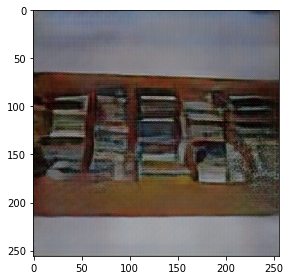

In [55]:
[out, tloss,k]=evaluate(gen, dis, vgg, wts, val_loader, gen_criterion, dis_criterion,device_gpu)
print(k)
print_image(out.cpu())

## Dynamic Quantization

In [74]:
dq_model = QuantFlatNet(phil,phir,4)

ckpt = torch.load(f_model,map_location=torch.device('cpu'))

dq_model.load_state_dict(ckpt['gen_state_dict'])
# print_size_of_model(dq)

import torch.quantization
dq_model.eval()
dq_model.fuse_model()
# quantized_model = torch.quantization.quantize_dynamic(
#     gen, mapping={'torch.nn.modules.conv.Conv2d':'torch.nn.qat.modules.conv.Conv2d'}, dtype=torch.qint8)
dq_model.qconfig = torch.quantization.default_qconfig
# print(gen.qconfig)
torch.quantization.prepare(dq_model, inplace=True)
# print(gen)
torch.quantization.convert(dq_model, inplace=True)

QuantFlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): QuantizedConvReLU2d(4, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (1): Identity()
        (2): Identity()
        (3): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (4): Identity()
        (5): Identity()
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
          (0): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(2, 2), scale=1.0, zero_point=0, padding=(1, 1))
          (1): Identity()
          (2): Identity()
          (3): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
          (4): Identity()
          (5): Identity()
        )
      )
    )
  )
  (down2): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
  

In [75]:
vgg_cpu = Vgg16(requires_grad=False).to(device_cpu)
dis_cpu = Discriminator().to(device_cpu)

1
0.5
0.5


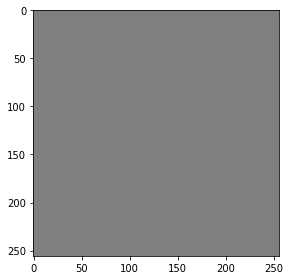

In [76]:
[out, tloss,k]=evaluate(dq_model, dis_cpu, vgg_cpu, wts, val_loader, gen_criterion, dis_criterion,device_cpu)
print(k)
print_image(out)

In [77]:
print_size_of_model(dq_model)

Size (MB): 77.02187


## Static Quantization

In [79]:
sq_model = QuantFlatNet(phil,phir,4)

sq_model.load_state_dict(ckpt['gen_state_dict'])


sq_model.eval()
sq_model.fuse_model()
# quantized_model = torch.quantization.quantize_dynamic(
#     gen, mapping={'torch.nn.modules.conv.Conv2d':'torch.nn.qat.modules.conv.Conv2d'}, dtype=torch.qint8)
sq_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# print(gen.qconfig)
torch.quantization.prepare(sq_model,inplace=True)

QuantFlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): ConvReLU2d(
          (0): Conv2d(
            4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
            (activation_post_process): HistogramObserver()
          )
          (1): ReLU(
            inplace=True
            (activation_post_process): HistogramObserver()
          )
        )
        (1): Identity()
        (2): Identity()
        (3): ConvReLU2d(
          (0): Conv2d(
            128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
            (activation_post_process): HistogramObserver()
          )
          (1): ReLU(
            inplace=True
            (activation_post_process): HistogramObserver()
          )
        )
        (4): Identity()
        (5): Identity()
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
          (0): ConvReLU2d(
            (0): Conv2d(
              128, 256

In [83]:
for i in range(10):
    [out, tloss,k]=evaluate(sq_model, dis_cpu, vgg_cpu, wts, val_loader, gen_criterion, dis_criterion,device_cpu)
    print(tloss)
    print(k)

2.4198999404907227
1
2.415419101715088
1
2.4177656173706055
1
2.4173941612243652
1
2.4170260429382324
1
2.418691635131836
1
2.4183034896850586
1
2.4182138442993164
1
2.4188098907470703
1
2.4181530475616455
1


In [85]:
torch.quantization.convert(sq_model,inplace=True)

QuantFlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): QuantizedConvReLU2d(4, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.22448532283306122, zero_point=1, padding=(1, 1))
        (1): Identity()
        (2): Identity()
        (3): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.15049397945404053, zero_point=1, padding=(1, 1))
        (4): Identity()
        (5): Identity()
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
          (0): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(2, 2), scale=0.15987849235534668, zero_point=1, padding=(1, 1))
          (1): Identity()
          (2): Identity()
          (3): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.15027086436748505, zero_point=1, padding=(1, 1))
          (4): Identity()
          (5): Identity()
        )
      )
    )
  )
  (down2): down(
    (mpconv): Seq

10
0.0006308627
0.75058335


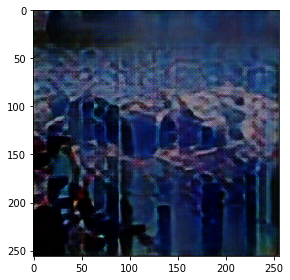

In [106]:
[out, tloss,k]=evaluate(sq_model, dis_cpu, vgg_cpu, wts, val_loader, gen_criterion, dis_criterion,device_cpu)
print(k)
print_image(out)

## Quantization aware training

In [99]:
def train_one_epoch(gen, dis, vgg, wts, optim_gen, optim_dis, train_loader, val_loader, gen_criterion, dis_criterion, device, vla, e, savedir, train_error, val_error, disc_err):
	i = 0
	
	for X_train, Y_train in train_loader:
		X_train, Y_train = X_train.to(device), Y_train.to(device)
		batchsize = X_train.shape[0]
		ones_const = Variable(torch.ones(batchsize, 1)).to(device)
		target_real = Variable(torch.rand(batchsize,1)*0.5 + 0.7).to(device)
		target_fake = Variable(torch.rand(batchsize,1)*0.3).to(device)
		# print(X_train.shape)
		# print(Y_train.shape)
		for param in gen.parameters():
			param.requires_grad = False
			
		for param in dis.parameters():
			param.requires_grad = True

		optim_dis.zero_grad()
		dis.train()
		high_res_real = Variable(Y_train)
		high_res_fake = gen(X_train)
		dis_loss = dis_criterion(dis(high_res_real), target_real) + dis_criterion(dis(Variable(high_res_fake.data)), target_fake)
		dis_loss.backward()
		optim_dis.step()
		disc_err.append(dis_loss.item())


		for param in gen.parameters():
			param.requires_grad = True
			
		for param in dis.parameters():
			param.requires_grad = False

		optim_gen.zero_grad()
		gen.train()
		# a = list(fcnet.parameters())[0].clone()
		Xout = gen(X_train)
		features_y = vgg(Y_train)
		features_x = vgg(Xout)
		loss = wts[0]*gen_criterion(Y_train, Xout)+(wts[1]*gen_criterion(features_y.relu2_2, features_x.relu2_2))+(wts[1]*gen_criterion(features_y.relu4_3, features_x.relu4_3))+wts[2]*dis_criterion(dis(Xout), ones_const)
		loss.backward()
		optim_gen.step()
		train_error.append(loss.item())
		Xvalout, vloss, k= evaluate(gen, dis, vgg, wts, val_loader, gen_criterion, dis_criterion, device)
		val_error.append(vloss)
		if vloss < vla:
			vla = vloss
			Xvalout = Xvalout.cpu()
			ims = Xvalout.detach().numpy()
			ims = ims[0, :, :, :]
			ims = np.swapaxes(np.swapaxes(ims,0,2),0,1)
			ims = (ims-np.min(ims))/(np.max(ims)-np.min(ims))
         
			skimage.io.imsave(savedir+('/best%d' % e), ims)
			dict_save = {
			'gen_state_dict': gen.state_dict(),
			'dis_state_dict': dis.state_dict(),
			'optimizerG_state_dict': optim_gen.state_dict(),
			'optimizerD_state_dict': optim_dis.state_dict(),
			'train_err': train_error,
			'val_err': val_error,
			'disc_err': disc_err,
			'last_finished_epoch': e}
			torch.save(dict_save, savedir+('/best%d' % e))
			print('Saved best')
		print('Epoch and Iterations::'+str(e)+','+str(i))
		print('Train and Val Loss:'+str(loss.item())+','+str(vloss))
		i += 1
	return train_error, val_error, disc_err, vla, Xvalout

In [90]:
ei = ckpt['last_finished_epoch'] + 1
val_error = ckpt['val_err']
train_error = ckpt['train_err']
vla = min(ckpt['val_err'])
disc_err=ckpt['disc_err']
e=ei

In [108]:
qat_model = QuantFlatNet(phil,phir,4).to(device_gpu)

ckpt = torch.load(f_model,map_location=torch.device('cuda'))

qat_model.eval()
qat_model.load_state_dict(ckpt['gen_state_dict'])


qat_model.fuse_model()
qat_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(qat_model, inplace=True)

QuantFlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): ConvReLU2d(
          4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
          (activation_post_process): FakeQuantize(
            fake_quant_enabled=True, observer_enabled=True,            scale=None, zero_point=None
            (activation_post_process): MovingAverageMinMaxObserver(min_val=None, max_val=None)
          )
          (weight_fake_quant): FakeQuantize(
            fake_quant_enabled=True, observer_enabled=True,            scale=None, zero_point=None
            (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=None, max_val=None)
          )
        )
        (1): Identity()
        (2): Identity()
        (3): ConvReLU2d(
          128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
          (activation_post_process): FakeQuantize(
            fake_quant_enabled=True, observer_enabled=True,            scale=None, zero_point=None
    

In [ ]:
for e in range(ei,ei+5): #change this
	train_error, val_error, disc_err, vla, Xvalout = train_one_epoch(qat_model, dis, vgg, wts, optim_gen, optim_dis, train_loader, val_loader, gen_criterion, dis_criterion, device_gpu, vla, e, savedir, train_error, val_error, disc_err)
	Xvalout = Xvalout.cpu()
	ims = Xvalout.detach().numpy()
	ims = ims[0, :, :, :]
	ims = np.swapaxes(np.swapaxes(ims,0,2),0,1)
	ims = (ims-np.min(ims))/(np.max(ims)-np.min(ims))
	skimage.io.imsave(savedir+'/latest.png', ims)

	dict_save = {
			'gen_state_dict': gen.state_dict(),
			'dis_state_dict': dis.state_dict(),
			'optimizerG_state_dict': optim_gen.state_dict(),
			'optimizerD_state_dict': optim_dis.state_dict(),
			'train_err': train_error,
			'val_err': val_error,
			'disc_err': disc_err,
			'last_finished_epoch': e,
			'opt': opt,
			'vla': vla}
	torch.save(dict_save, savedir+'/latest.tar')
	savename = '/phil_epoch%d' % e
	np.save(savedir+savename, gen.PhiL.detach().cpu().numpy())
	savename = '/phir_epoch%d' % e
	np.save(savedir+savename, gen.PhiR.detach().cpu().numpy())
	if e%2 == 0:
		for param_group in optim_gen.param_groups:
			param_group['lr'] = param_group['lr']/2
		for param_group in optim_dis.param_groups:
			param_group['lr'] = param_group['lr']/2

	print('Saved latest')

In [ ]:
train_error, val_error, disc_err, vla, Xvalout = train_one_epoch(qat_model.to(device_gpu), dis, vgg, wts, optim_gen, optim_dis, train_loader, val_loader, gen_criterion, dis_criterion, device_gpu, vla, e, savedir, train_error, val_error, disc_err)

Epoch and Iterations::16,0
Train and Val Loss:2.2301108837127686,3.1299854278564454
Epoch and Iterations::16,1
Train and Val Loss:2.3857176303863525,3.1377958416938783
Epoch and Iterations::16,2
Train and Val Loss:2.746493339538574,3.1574272394180296
Epoch and Iterations::16,3
Train and Val Loss:2.7094807624816895,3.1494606733322144
Epoch and Iterations::16,4
Train and Val Loss:3.125678300857544,3.145427703857422
Epoch and Iterations::16,5
Train and Val Loss:2.7397472858428955,3.1540237784385683
Epoch and Iterations::16,6
Train and Val Loss:1.8890478610992432,3.1170145630836488
Epoch and Iterations::16,7
Train and Val Loss:2.3645923137664795,3.143195557594299
Epoch and Iterations::16,8
Train and Val Loss:2.5426158905029297,3.1683329820632933
Epoch and Iterations::16,9
Train and Val Loss:2.462308883666992,3.15866357088089
Epoch and Iterations::16,10
Train and Val Loss:2.3050930500030518,3.13267982006073
Epoch and Iterations::16,11
Train and Val Loss:2.6361637115478516,3.142502284049988


In [110]:
quantized_model = torch.quantization.convert(qat_model.to(device_cpu).eval(), inplace=False)
quantized_model.eval()

QuantFlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): QuantizedConvReLU2d(4, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.29910171031951904, zero_point=0, padding=(1, 1))
        (1): Identity()
        (2): Identity()
        (3): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.19409745931625366, zero_point=0, padding=(1, 1))
        (4): Identity()
        (5): Identity()
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
          (0): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(2, 2), scale=0.19783194363117218, zero_point=0, padding=(1, 1))
          (1): Identity()
          (2): Identity()
          (3): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.18551144003868103, zero_point=0, padding=(1, 1))
          (4): Identity()
          (5): Identity()
        )
      )
    )
  )
  (down2): down(
    (mpconv): Seq

10
0.0006308627
0.75058335


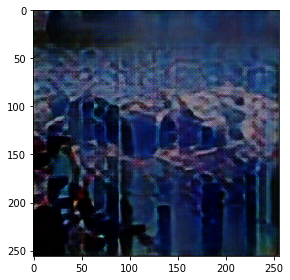

In [111]:
[out, tloss,k]=evaluate(sq_model, dis_cpu, vgg_cpu, wts, val_loader, gen_criterion, dis_criterion,device_cpu)
print(k)
print_image(out)

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
torch.Size([1, 1024, 1280])
<class 'torch.Tensor'>


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


torch.Size([4, 500, 620])


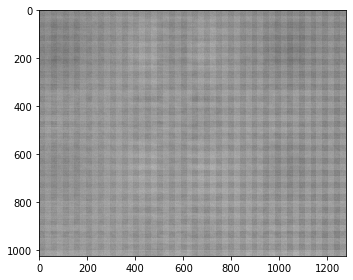

In [114]:

f_meas = '/Data/Amplitude Mask/dataset/caps_1cap/n02012849/n02012849_5172..png'
import torchvision
from PIL import Image
import skimage as sk

meas2=Image.open(f_meas)
print(type(meas2))

meas = sk.io.imread(f_meas)
meas=sk.img_as_float64(meas)
print(type(meas))
tf2=torchvision.transforms.ToTensor()
meas2=tf2(meas2)
print(meas2.shape)
print(type(meas2))
skimage.io.imshow(meas)
# 
# meas = totensor(meas)

meas2 = demosaic_raw(meas2)
print(meas2.shape)

6.387084e-09
0.8300003
(256, 256, 3)


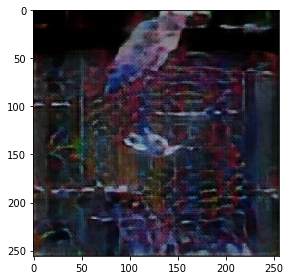

In [115]:
out=quantized_model(meas2.unsqueeze(0))
ims = out.detach().numpy()
print(np.min(ims))
print(np.max(ims))
ims = ims[0, :, :, :]
ims = np.swapaxes(np.swapaxes(ims,0,2),0,1)
print(ims.shape)
skimage.io.imshow(ims)